In [ ]:
import warnings, os, math
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.impute import SimpleImputer
np.random.seed(42)
from sklearn.pipeline import Pipeline

In [ ]:
from ydata_profiling import ProfileReport

1. Summarize the data: Its a powerlifting custom dataset that gives a score called Wilks score. A Wilks score in powerlifting is a measure that gives a lifter's strength relative to their bodyweight, allowing for comparisons between different weight classes and genders. Since I don't want to choose other common datasets from Kaggle or Scikit Learn, I created this custom dataset, with wilks score
2. How much data is present: There are 1981 samples with 9 attributes
3. What attributes are continuous valued: 8 attributes are continuous valued: 'Age', 'Powerlifting_Exp_Years', 'Bodyweight_kg', 'Squat_PR_kg', 'Deadlift_PR_kg', 'Bench_PR_kg', 'Height_cm', 'Wilks_Score'
4. Which attributes are categorical: One categorical variable: 'Gender', and I'm assigning a strength coefficient 0.8 for Female and 1 for Male which is relevant to Wilks Score, rather than the plain 0/1 flags.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/powerlifting_custom_dataset_wilks.csv')
print("Dataset Summary:")
print(f"Total samples: {df.shape[0]}")
print(f"Total attributes: {df.shape[1]}")
print("\nDataset Info:")
print(df.info())

print("\nMissing Values per Column:")
print(df.isnull().sum())

continuous_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Continuous (numeric) features:")
print(continuous_features)
print("Categorical features:")
print(categorical_features)

Dataset Summary:
Total samples: 1981
Total attributes: 9

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981 entries, 0 to 1980
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     1981 non-null   int64  
 1   Gender                  1981 non-null   object 
 2   Powerlifting_Exp_Years  1981 non-null   float64
 3   Bodyweight_kg           1981 non-null   float64
 4   Squat_PR_kg             1981 non-null   float64
 5   Deadlift_PR_kg          1981 non-null   float64
 6   Bench_PR_kg             1981 non-null   float64
 7   Height_cm               1981 non-null   float64
 8   Wilks_Score             1981 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 139.4+ KB
None

Missing Values per Column:
Age                       0
Gender                    0
Powerlifting_Exp_Years    0
Bodyweight_kg             0
Squat_PR_kg               0
De

1. Below displayed the statistical measures for the attributes along with histogram plots
2. Noticeable traits for key attributes: Higher the Wilks score mean higher the strength, also most of the attributes follow normal distribution, which implies there aren't any clear evidence of skewness or any irregularities in the data. There aren't any null values in the dataset as well.

Statistical Summary:


count        mean        std    min    25%    50%  \
Age                     1981.0   38.702675  12.116269   18.0   28.0   39.0   
Powerlifting_Exp_Years  1981.0   10.887431   6.645968    0.5    5.4   10.2   
Bodyweight_kg           1981.0   81.164361  13.189316   45.0   71.8   81.1   
Squat_PR_kg             1981.0  183.506209  43.916196   76.8  152.4  180.4   
Deadlift_PR_kg          1981.0  189.043513  40.072244   72.9  160.6  186.2   
Bench_PR_kg             1981.0  129.806058  28.448637   54.3  109.1  128.4   
Height_cm               1981.0  174.976022   9.822421  150.0  168.3  175.1   
Wilks_Score             1981.0  381.473801  62.344040  185.0  333.4  386.9   

                          75%    max  
Age                      49.0   59.0  
Powerlifting_Exp_Years   15.8   25.0  
Bodyweight_kg            90.2  123.7  
Squat_PR_kg             214.4  308.2  
Deadlift_PR_kg          216.8  317.9  
Bench_PR_kg             150.3  217.8  
Height_cm               181.7  200.0  
Wilks_Score             428.8  499.9

Age                       0
Gender                    0
Powerlifting_Exp_Years    0
Bodyweight_kg             0
Squat_PR_kg               0
Deadlift_PR_kg            0
Bench_PR_kg               0
Height_cm                 0
Wilks_Score               0
dtype: int64

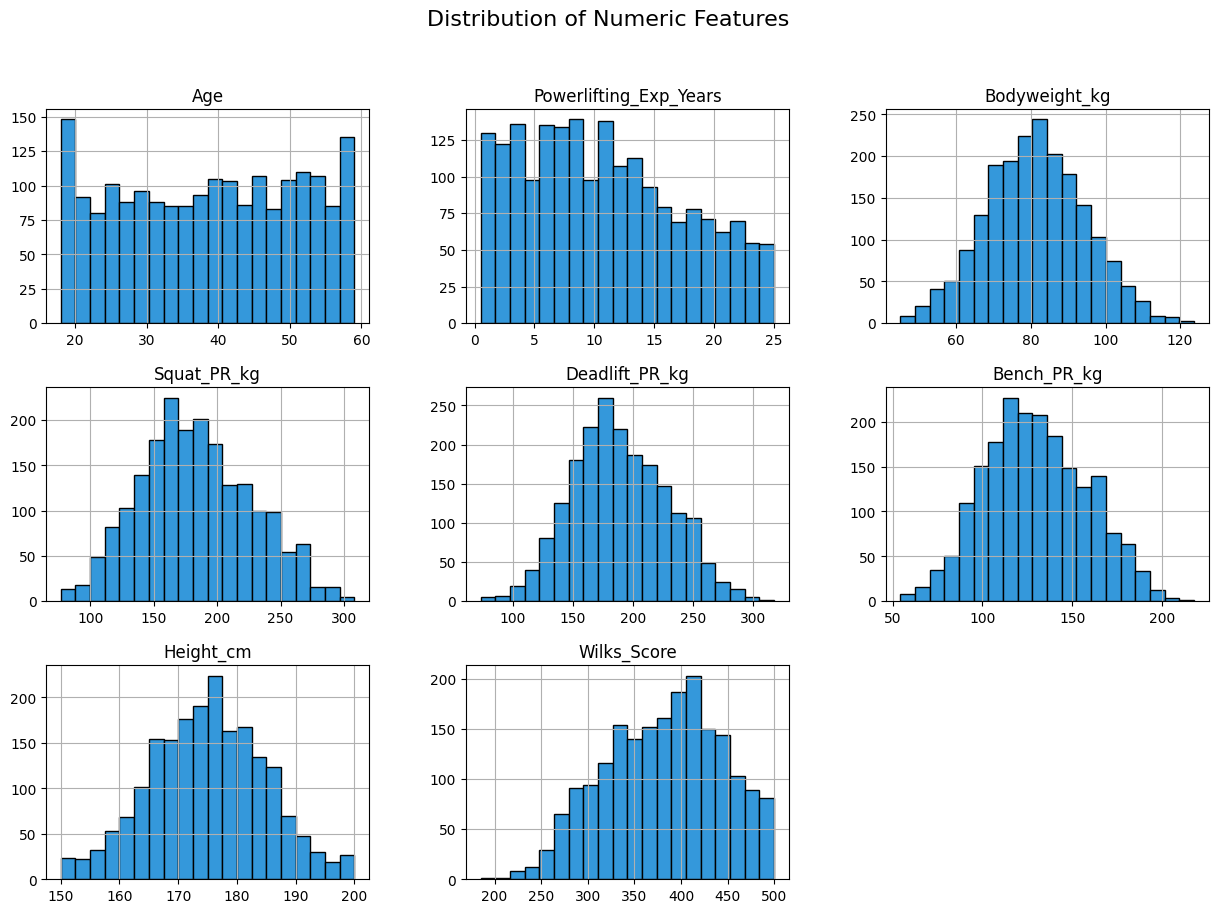

In [ ]:
print("Statistical Summary:")
display(df.describe().T)

display(df.isnull().sum())

numeric_cols = df.select_dtypes(include=[np.number]).columns

df[numeric_cols].hist(
    bins=20, figsize=(15, 10), edgecolor='black', color='#3498db'
)
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.show()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/powerlifting_custom_dataset_wilks.csv')

df['Gender'] = df['Gender'].map({'Female': 0.8, 'Male': 1.0}).astype(float)

X = df.drop(columns=['Wilks_Score'])
y = df['Wilks_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

1. From the below findings, we can see the features highly correlated with Wilks_Score are: Powerlifting_Exp_Years and Squat_PR_kg.
2. Features Highly correlated between them: Squat_PR_kg, Bench_PR_kg, Deadlift_PR_kg.

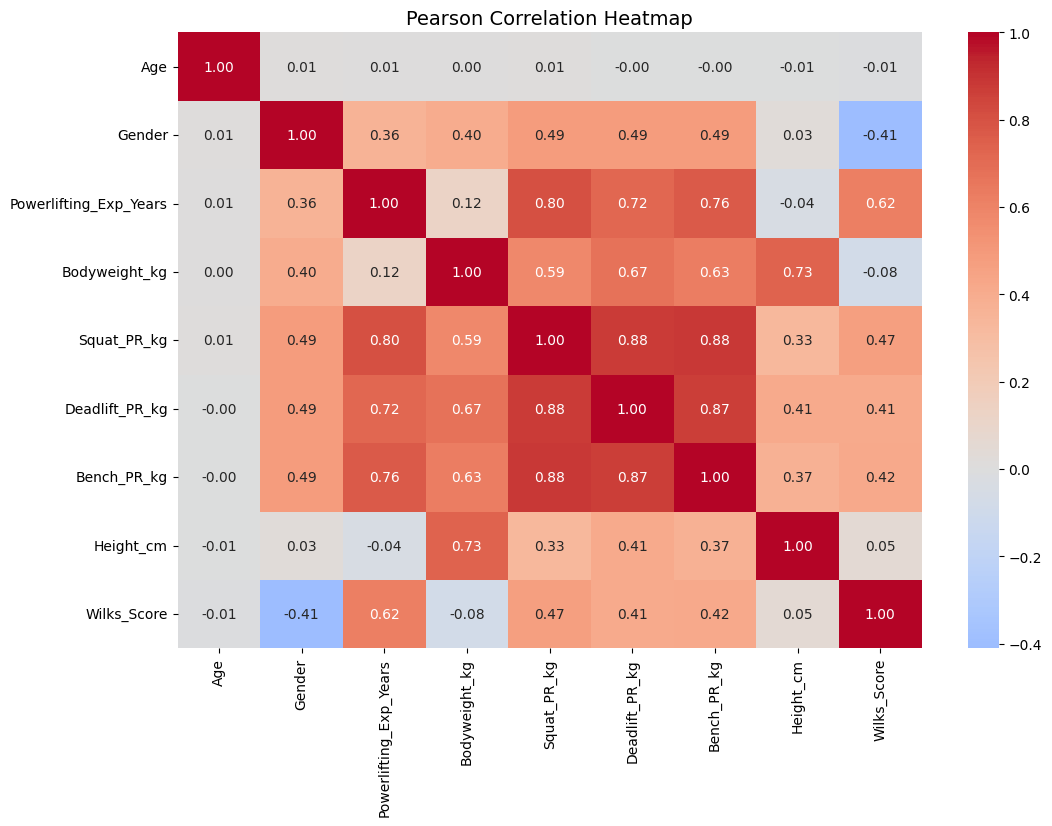


Top correlations with Wilks_Score:
Wilks_Score               1.000000
Powerlifting_Exp_Years    0.621832
Squat_PR_kg               0.467069
Bench_PR_kg               0.416463
Deadlift_PR_kg            0.405792
Height_cm                 0.047852
Age                      -0.013946
Bodyweight_kg            -0.081590
Gender                   -0.410882
Name: Wilks_Score, dtype: float64


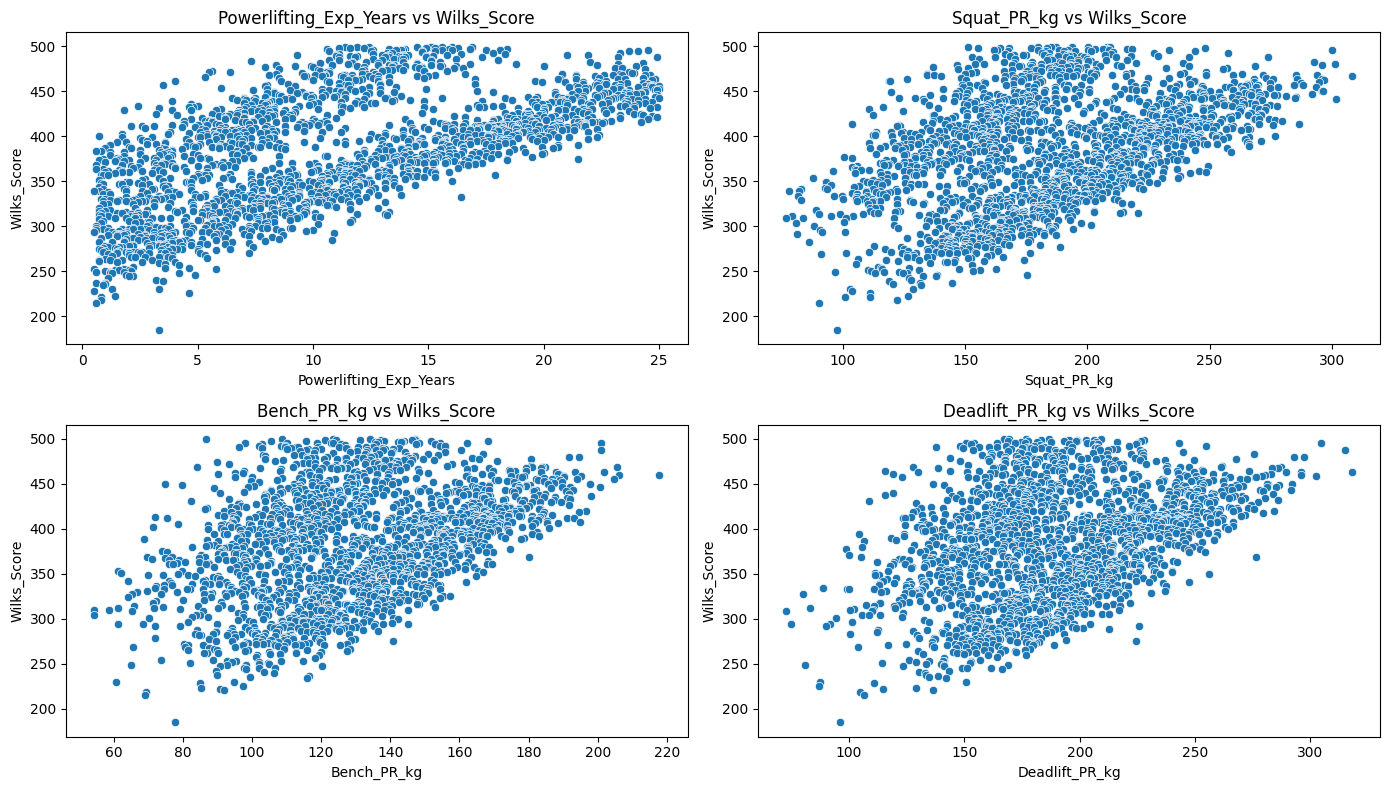

In [ ]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Pearson Correlation Heatmap", fontsize=14)
plt.show()

target = 'Wilks_Score'
corr_target = corr[target].sort_values(ascending=False)
print("\nTop correlations with Wilks_Score:")
print(corr_target)

top_corr_features = corr_target.index[1:5]

plt.figure(figsize=(14, 8))
for i, col in enumerate(top_corr_features):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=df[col], y=df[target])
    plt.title(f"{col} vs {target}")
plt.tight_layout()
plt.show()

# Overall dataset's profile summary

In [ ]:
profile = ProfileReport(df, title="Powerlifting Wilks score", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 71.89it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

1. Created few general functions for RMSE calculation and RMSE estimator for k-fold.
2. Ran linear regression with k fold
3. Solved for normal equation.
4. Ran a multiple loops with base SGD regressor for finding best set of hyperparameters.
5. Trained the SGDRegressor again with the same best set of hyperparameters over the training data set and we've predicted the y labels from the trained regressor and calculated the train, test RMSEs.
6. Plotted an epoc wise learning curve between training vs validation using the best set of hyperparameters that we've found.
7. Impact of penalty terms in this model training:
L2 regularization gave stable but slightly higher RMSE values on average, indicating mild underfitting due to uniform weight shrinkage. L1 penalty showed marginally higher RMSE and slightly more variance, suggesting that enforcing sparsity removed some useful correlated predictors. Elastic Net achieved the lowest mean CV RMSE (~14.97) with α=0.0001 and l1_ratio=0.3, effectively balancing sparsity and smooth regularization.
8. Impact of other best set hyperparameters in this model training: The initial learning rate (η₀=0.001) offered a steady convergence and avoided overshooting, while 'invscaling' learning rate schedule ensured smooth decay and stable optimization over epochs. A small regularization strength (α=0.0001) prevented overfitting but still allowed sufficient flexibility for fitting meaningful relationships in the data. The moderate L1 ratio (0.3) further stabilized convergence, giving smoother and more consistent learning curves.

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

kf = KFold(n_splits=4, shuffle=True, random_state=42)

def cv_rmse_estimator(estimator, X, y, kf):
    rmses = []
    for train_idx, val_idx in kf.split(X):
        est = clone(estimator)
        est.fit(X[train_idx], y.iloc[train_idx])
        yv = est.predict(X[val_idx])
        rmses.append(rmse(y.iloc[val_idx], yv))
    return np.mean(rmses), np.std(rmses)

lin_reg = LinearRegression()

cv_mean, cv_std = cv_rmse_estimator(lin_reg, X_train_scaled, y_train, kf)
print(f"Linear Regression CV RMSE: {cv_mean:.4f} ± {cv_std:.4f}")

lin_reg.fit(X_train_scaled, y_train)

y_train_pred = lin_reg.predict(X_train_scaled)
y_test_pred = lin_reg.predict(X_test_scaled)

train_rmse = rmse(y_train, y_train_pred)
test_rmse = rmse(y_test, y_test_pred)

print(f"Linear Regression Train RMSE: {train_rmse:.4f}")
print(f"Linear Regression Test RMSE: {test_rmse:.4f}")

Linear Regression CV RMSE: 14.9592 ± 0.2983
Linear Regression Train RMSE: 14.8837
Linear Regression Test RMSE: 16.0560


In [ ]:
X_design = np.hstack([np.ones((X_train_scaled.shape[0],1)), X_train_scaled])
w_normal = np.linalg.pinv(X_design.T @ X_design) @ X_design.T @ y_train.values
y_train_pred_cf = X_design @ w_normal
cf_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_cf))

print(f"Closed-form train RMSE: {cf_rmse_train:.6f}")

Closed-form train RMSE: 14.883711


In [ ]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
penalties = ['l2', 'l1', 'elasticnet']
learning_rates = ['invscaling', 'optimal']
eta0_values = [0.001, 0.01, 0.05]
max_iter=2000

best_cfg = None
best_cv = float('inf')
results = []

for learning_rate in learning_rates:
    for eta0 in eta0_values:
        for penalty in penalties:
            for alpha in alphas:
                l1_ratio = 0.3 if penalty == 'elasticnet' else 0.15
                est = SGDRegressor(
                    penalty=penalty,
                    alpha=alpha,
                    l1_ratio=l1_ratio,
                    learning_rate=learning_rate,
                    eta0=eta0,
                    max_iter=2000,
                    tol=1e-4,
                    random_state=42,
                    warm_start=False
                )
                m, s = cv_rmse_estimator(est, X_train_scaled, y_train, kf)
                results.append({'penalty':penalty, 'alpha':alpha, 'l1_ratio':l1_ratio,
                                'learning_rate':learning_rate, 'eta0':eta0,
                                'cv_mean':m, 'cv_std':s})
                if m < best_cv:
                    best_cv = m
                    best_cfg = {'penalty':penalty, 'alpha':alpha, 'l1_ratio':l1_ratio,
                                'learning_rate':learning_rate, 'eta0':eta0}

res_df = pd.DataFrame(results).sort_values('cv_mean').reset_index(drop=True)
print("\n===== SGD Regularization Results (Top 5) =====")
print(res_df.head(5))
print(f"\nBest config: {best_cfg}")

# Train best model
best_est = SGDRegressor(**best_cfg, max_iter=2000, tol=1e-4, random_state=42)
best_est.fit(X_train_scaled, y_train)
train_rmse_sgd = rmse(y_train, best_est.predict(X_train_scaled))
test_rmse_sgd = rmse(y_test, best_est.predict(X_test_scaled))
print(f"SGD Train RMSE: {train_rmse_sgd:.4f}")
print(f"SGD Test RMSE: {test_rmse_sgd:.4f}")


===== SGD Regularization Results (Top 5) =====
      penalty    alpha  l1_ratio learning_rate   eta0    cv_mean    cv_std
0  elasticnet  0.00010      0.30    invscaling  0.001  14.968692  0.320075
1          l1  0.00100      0.15    invscaling  0.001  14.968779  0.319278
2          l1  0.00010      0.15    invscaling  0.001  14.969322  0.318520
3          l2  0.00010      0.15    invscaling  0.001  14.969444  0.320389
4          l1  0.00001      0.15    invscaling  0.001  14.969888  0.318420

Best config: {'penalty': 'elasticnet', 'alpha': 0.0001, 'l1_ratio': 0.3, 'learning_rate': 'invscaling', 'eta0': 0.001}
SGD Train RMSE: 14.8982
SGD Test RMSE: 16.0852


In [ ]:
best_est = SGDRegressor(
    penalty=best_cfg['penalty'],
    alpha=best_cfg['alpha'],
    l1_ratio=best_cfg['l1_ratio'],
    learning_rate=best_cfg['learning_rate'],
    eta0=best_cfg['eta0'],
    max_iter=max_iter,
    random_state=42
)

best_est.fit(X_train_scaled, y_train)

y_train_pred = best_est.predict(X_train_scaled)
y_test_pred = best_est.predict(X_test_scaled)

train_rmse = rmse(y_train, y_train_pred)
test_rmse = rmse(y_test, y_test_pred)

print(f"\nFinal SGD Model Performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")


Final SGD Model Performance:
Train RMSE: 14.9019
Test  RMSE: 16.0904


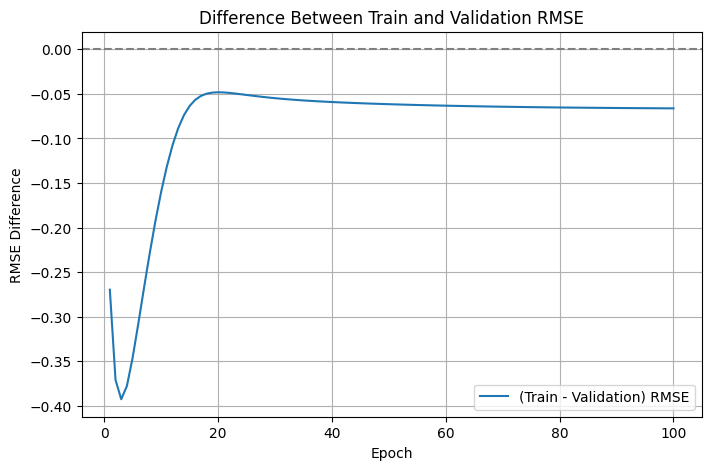

(15.074661368093803, 297.3439210988098)

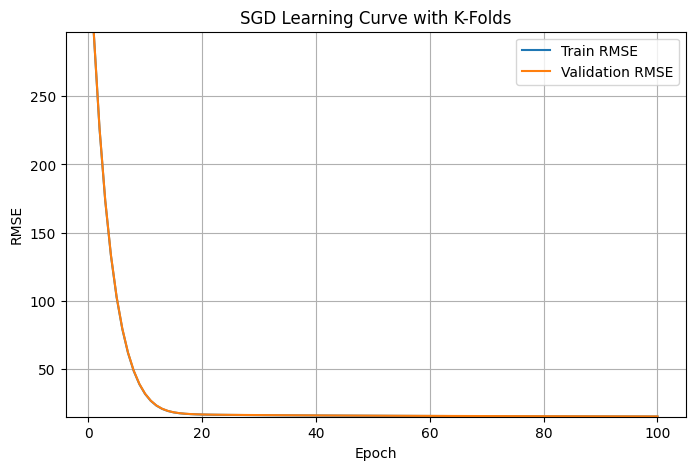

In [ ]:
train_rmse_hist = []
val_rmse_hist = []

best_est_param = {
    'penalty': best_cfg['penalty'],
    'alpha': best_cfg['alpha'],
    'l1_ratio': best_cfg['l1_ratio'],
    'learning_rate': best_cfg['learning_rate'],
    'eta0': best_cfg['eta0'],
    'max_iter': 1,
    'random_state': 42,
    'warm_start': True }

# Store one persistent model per fold
fold_models = []
for train_idx, val_idx in kf.split(X_train_scaled):
    est = SGDRegressor(**best_est_param)
    fold_models.append((est, train_idx, val_idx))

n_epochs = 100
for epoch in range(n_epochs):
    fold_train_rmse = []
    fold_val_rmse = []

    for est, train_idx, val_idx in fold_models:
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # 🔹 Continue training same model (warm_start=True makes this cumulative)
        est.fit(X_tr, y_tr)

        y_tr_pred = est.predict(X_tr)
        y_val_pred = est.predict(X_val)
        fold_train_rmse.append(rmse(y_tr, y_tr_pred))
        fold_val_rmse.append(rmse(y_val, y_val_pred))

    train_rmse_hist.append(np.mean(fold_train_rmse))
    val_rmse_hist.append(np.mean(fold_val_rmse))

plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1),
         np.array(train_rmse_hist) - np.array(val_rmse_hist),
         label='(Train - Validation) RMSE')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('RMSE Difference')
plt.title('Difference Between Train and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), train_rmse_hist, label='Train RMSE')
plt.plot(range(1, n_epochs+1), val_rmse_hist, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('SGD Learning Curve with K-Folds')
plt.legend()
plt.grid(True)

plt.ylim(min(train_rmse_hist + val_rmse_hist) * 0.99,
         max(train_rmse_hist + val_rmse_hist) * 1.005)

#Due to scale, I've displayed the epochwise difference Train vs Test curve as well as the learning curve.

1. I've repeated the same process, kind of integrated the loops for all hyperparameters and found out the best set.
2. Considering the train RMSE being 9.9305 and test RMSE being 10.4094, I feel that model is not extremely overfitted or underfitted since the gap between both of them is not that significant, however with really small gap between them, it signifies that our model is slightly overfitted

In [ ]:
poly_degrees = [2,3]

alphas = [1e-5, 1e-4, 1e-3, 1e-2]
penalties = ['l2', 'l1', 'elasticnet']
learning_rates = ['invscaling', 'optimal']
eta0_values = [0.001, 0.01, 0.05]

max_iter = 2000
tol = 1e-4
warm_start = True
random_state = 42

results_poly = []

for degree in poly_degrees:
    # Create polynomial feature transformer
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Scale again (important for SGD stability)
    scaler_poly = StandardScaler()
    X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
    X_test_poly_scaled = scaler_poly.transform(X_test_poly)

    for learning_rate in learning_rates:
        for eta0 in eta0_values:
            for penalty in penalties:
                for alpha in alphas:
                    l1_ratio = 0.4 if penalty == 'elasticnet' else 0.0

                    est = SGDRegressor(
                        penalty=penalty,
                        alpha=alpha,
                        l1_ratio=l1_ratio,
                        learning_rate=learning_rate,
                        eta0=eta0,
                        max_iter=max_iter,
                        tol=tol,
                        random_state=random_state,
                        warm_start=warm_start
                    )

                    # Perform CV RMSE evaluation
                    m, s = cv_rmse_estimator(est, X_train_poly_scaled, y_train, kf)

                    results_poly.append({
                        'degree': degree,
                        'penalty': penalty,
                        'alpha': alpha,
                        'l1_ratio': l1_ratio,
                        'learning_rate': learning_rate,
                        'eta0': eta0,
                        'cv_mean': m,
                        'tol': tol,
                        'cv_std': s
                    })

res_poly_df = pd.DataFrame(results_poly).sort_values('cv_mean').reset_index(drop=True)
print("\nPolynomial Regression + SGD CV results (top 10):")
print(res_poly_df.head(10))

best_poly_cfg = res_poly_df.iloc[0].to_dict()
print("\nBest Polynomial Config by CV:", best_poly_cfg)


best_degree = int(best_poly_cfg['degree'])
poly_final = PolynomialFeatures(degree=best_degree, include_bias=False)
X_train_poly_final = poly_final.fit_transform(X_train_scaled)
X_test_poly_final = poly_final.transform(X_test_scaled)

scaler_poly_final = StandardScaler()
X_train_poly_final_scaled = scaler_poly_final.fit_transform(X_train_poly_final)
X_test_poly_final_scaled = scaler_poly_final.transform(X_test_poly_final)

best_poly_est = SGDRegressor(
    penalty=best_poly_cfg['penalty'],
    alpha=best_poly_cfg['alpha'],
    l1_ratio=best_poly_cfg['l1_ratio'],
    learning_rate=best_poly_cfg['learning_rate'],
    eta0=best_poly_cfg['eta0'],
    max_iter=max_iter,
    tol=tol,
    random_state=random_state
)

best_poly_est.fit(X_train_poly_final_scaled, y_train)


y_train_pred_poly = best_poly_est.predict(X_train_poly_final_scaled)
y_test_pred_poly = best_poly_est.predict(X_test_poly_final_scaled)

train_rmse_poly = rmse(y_train, y_train_pred_poly)
test_rmse_poly = rmse(y_test, y_test_pred_poly)

print(f"\nFinal Polynomial SGD Model (degree={best_degree}) Performance:")
print(f"Train RMSE: {train_rmse_poly:.4f}")
print(f"Test  RMSE: {test_rmse_poly:.4f}")


Polynomial Regression + SGD CV results (top 10):
   degree     penalty    alpha  l1_ratio learning_rate   eta0    cv_mean  \
0       2          l1  0.01000       0.0    invscaling  0.001  10.261463   
1       2          l1  0.00100       0.0    invscaling  0.001  10.284504   
2       2          l1  0.00010       0.0    invscaling  0.001  10.293389   
3       2  elasticnet  0.00010       0.4    invscaling  0.001  10.294339   
4       2          l1  0.00010       0.0    invscaling  0.010  10.294967   
5       2          l1  0.00001       0.0    invscaling  0.001  10.295569   
6       2  elasticnet  0.00001       0.4    invscaling  0.001  10.295661   
7       2          l2  0.00001       0.0    invscaling  0.001  10.295723   
8       2          l2  0.00010       0.0    invscaling  0.001  10.297151   
9       2          l1  0.00100       0.0    invscaling  0.010  10.298912   

      tol    cv_std  
0  0.0001  0.471581  
1  0.0001  0.462442  
2  0.0001  0.474322  
3  0.0001  0.474626  
4  

Tracking learning curve for Polynomial Regression (degree=2)


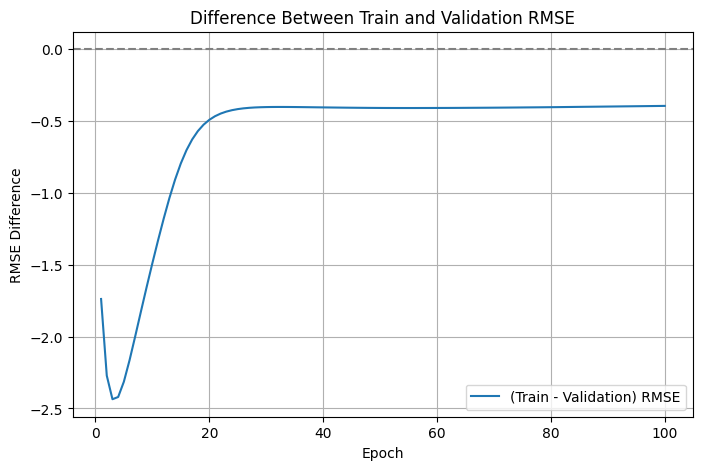

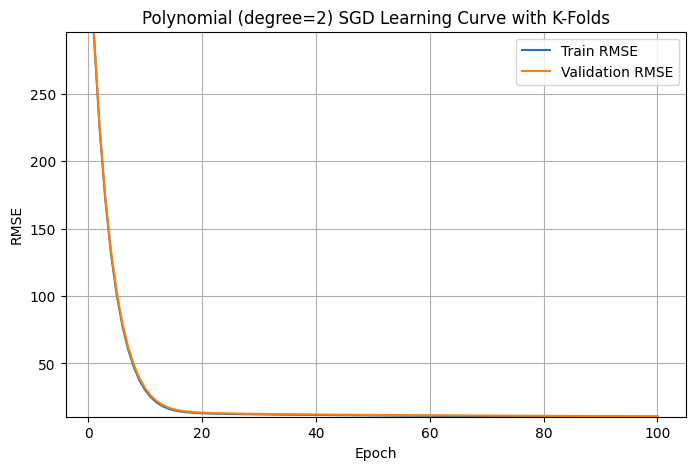

In [ ]:
best_poly_cfg = res_poly_df.iloc[0].to_dict()
best_degree = int(best_poly_cfg['degree'])
print(f"Tracking learning curve for Polynomial Regression (degree={best_degree})")

poly = PolynomialFeatures(degree=best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

best_est_params_poly = {
    'penalty': best_poly_cfg['penalty'],
    'alpha': best_poly_cfg['alpha'],
    'l1_ratio': best_poly_cfg['l1_ratio'],
    'learning_rate': best_poly_cfg['learning_rate'],
    'eta0': best_poly_cfg['eta0'],
    'max_iter': 1,
    'tol': tol,
    'random_state': 42,
    'warm_start': True }

train_rmse_hist = []
val_rmse_hist = []

fold_models = []
for train_idx, val_idx in kf.split(X_train_poly_scaled):
    est = SGDRegressor(**best_est_params_poly)
    fold_models.append((est, train_idx, val_idx))

n_epochs = 100
for epoch in range(n_epochs):
    fold_train_rmse = []
    fold_val_rmse = []

    for est, train_idx, val_idx in fold_models:
        X_tr, X_val = X_train_poly_scaled[train_idx], X_train_poly_scaled[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        est.fit(X_tr, y_tr)

        y_tr_pred = est.predict(X_tr)
        y_val_pred = est.predict(X_val)
        fold_train_rmse.append(rmse(y_tr, y_tr_pred))
        fold_val_rmse.append(rmse(y_val, y_val_pred))

    train_rmse_hist.append(np.mean(fold_train_rmse))
    val_rmse_hist.append(np.mean(fold_val_rmse))

plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1),
         np.array(train_rmse_hist) - np.array(val_rmse_hist),
         label='(Train - Validation) RMSE')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('RMSE Difference')
plt.title('Difference Between Train and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), train_rmse_hist, label='Train RMSE')
plt.plot(range(1, n_epochs+1), val_rmse_hist, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title(f'Polynomial (degree={best_degree}) SGD Learning Curve with K-Folds')
plt.legend()
plt.grid(True)

plt.ylim(min(train_rmse_hist + val_rmse_hist) * 1,
         max(train_rmse_hist + val_rmse_hist) * 1)

plt.show()
#Due to scale, I've displayed the epochwise difference Train vs Test curve as well as the learning curve.

1. The train RMSEs for the models:
Linear Regression - 14.8837
Closed Form Solution - 14.883711
Linear Regression with SGD - 14.9019
Polynomial Regression - 9.9305
2. Considering the best train RMSE, polynomial regression also produced the least test RMSE - 10.4094 among other models, which makes it my best model for Powerlifting Wilks score prediction.
3. The final model achieved a test RMSE of 10.41 on a mean Wilks Score of ~ 381.47, corresponding to an average prediction error of roughly 2.7% relative to the target scale. This low relative error indicates that the polynomial model generalizes well and captures most of the variance in the data without significant overfitting.